# HuBMAP PyTorch ⚡ MONAI Train & Infer

## Combine powers of [PyTorch Lightning](https://www.pytorchlightning.ai/) and [MONAI](https://monai.io/)

# Installs

In [1]:
# !pip install monai staintools spams --no-index --find-links=../input/hubmap-downloads

In [2]:
# !pip install pytorch-lightning

In [3]:
# !pip install seaborn

In [4]:
# !pip install tifffile

In [5]:
# !pip install monai staintools spams

In [1]:
# !pip install ipywidgets widgetsnbextension

# Imports

In [2]:
from pathlib import Path
from typing import Any
from typing import Callable
from typing import Dict
from typing import Optional
from typing import Tuple

import monai
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import staintools
import tifffile
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from monai.data import CSVDataset
from monai.data import DataLoader
from monai.data import ImageReader
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm

# Paths & Settings

In [38]:
KAGGLE_DIR = Path('..') # Path("/") / "kaggle"

INPUT_DIR = KAGGLE_DIR / "data"
OUTPUT_DIR = KAGGLE_DIR / "working"

COMPETITION_DATA_DIR = INPUT_DIR # / "hubmap-organ-segmentation"

TRAIN_PREPARED_CSV_PATH = "train_prepared.csv"
VAL_PRED_PREPARED_CSV_PATH = "val_pred_prepared.csv"
TEST_PREPARED_CSV_PATH = "test_prepared.csv"

N_SPLITS = 4
RANDOM_SEED = 2022
SPATIAL_SIZE = 1024
VAL_FOLD = 0
NUM_WORKERS = 16
BATCH_SIZE = 16
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 0.0
FAST_DEV_RUN = False
GPUS = [3]
MAX_EPOCHS = 10
PRECISION = 16
DEBUG = False

DEVICE = "cuda"
THRESHOLD = 0.5

# Prepare DataFrames (Add paths and create folds)

In [13]:
def add_path_to_df(df: pd.DataFrame, data_dir: Path, type_: str, stage: str) -> pd.DataFrame:
    ending = ".tiff" if type_ == "image" else ".npy"
    
    dir_ = str(data_dir / f"{stage}_{type_}s") #if type_ == "image" else f"{stage}_{type_}s"
    df[type_] = dir_ + "/" + df["id"].astype(str) + ending
    return df


def add_paths_to_df(df: pd.DataFrame, data_dir: Path, stage: str) -> pd.DataFrame:
    df = add_path_to_df(df, data_dir, "image", stage)
    df = add_path_to_df(df, data_dir, "mask", stage)
    return df


def create_folds(df: pd.DataFrame, n_splits: int, random_seed: int) -> pd.DataFrame:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    for fold, (_, val_idx) in enumerate(skf.split(X=df, y=df["organ"])):
        df.loc[val_idx, "fold"] = fold

    return df


def prepare_data(data_dir: Path, stage: str, n_splits: int, random_seed: int) -> None:
    df = pd.read_csv(data_dir / f"{stage}.csv")
    df = add_paths_to_df(df, data_dir, stage)

    if stage == "train":
        df = create_folds(df, n_splits, random_seed)

    filename = f"{stage}_prepared.csv"
    df.to_csv(filename, index=False)

    print(f"Created {filename} with shape {df.shape}")

    return df

In [14]:
train_df = prepare_data(COMPETITION_DATA_DIR, "train", N_SPLITS, RANDOM_SEED)
test_df = prepare_data(COMPETITION_DATA_DIR, "test", N_SPLITS, RANDOM_SEED)

Created train_prepared.csv with shape (351, 13)
Created test_prepared.csv with shape (1, 9)


In [15]:
train_df

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,image,mask,fold
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,../data/train_images/10044.tiff,../data/train_masks/10044.npy,3.0
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,../data/train_images/10274.tiff,../data/train_masks/10274.npy,0.0
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,../data/train_images/10392.tiff,../data/train_masks/10392.npy,0.0
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,../data/train_images/10488.tiff,../data/train_masks/10488.npy,0.0
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,../data/train_images/10610.tiff,../data/train_masks/10610.npy,3.0
5,10611,kidney,HPA,3000,3000,0.4,4,730193 18 733191 25 736191 25 739152 65 742149...,68.0,Female,../data/train_images/10611.tiff,../data/train_masks/10611.npy,3.0
6,10651,largeintestine,HPA,3000,3000,0.4,4,1240229 12 1243227 15 1246223 26 1249221 29 12...,83.0,Male,../data/train_images/10651.tiff,../data/train_masks/10651.npy,1.0
7,10666,prostate,HPA,3000,3000,0.4,4,2698231 7 2701231 7 2704226 16 2707221 25 2710...,57.0,Male,../data/train_images/10666.tiff,../data/train_masks/10666.npy,2.0
8,10703,spleen,HPA,3000,3000,0.4,4,811259 262 814258 264 817257 266 820256 267 82...,50.0,Female,../data/train_images/10703.tiff,../data/train_masks/10703.npy,3.0
9,10892,largeintestine,HPA,3000,3000,0.4,4,523786 3 526784 8 529782 8 532778 9 535642 25 ...,79.0,Female,../data/train_images/10892.tiff,../data/train_masks/10892.npy,2.0


In [16]:
test_df

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,image,mask
0,10078,spleen,Hubmap,2023,2023,0.4945,4,../data/test_images/10078.tiff,../data/test_masks/10078.npy


# Save Train Masks as NumPy Arrays

In [17]:
def rle2mask(mask_rle: str, shape: Tuple[int, int]) -> np.ndarray:
    """
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return
    Returns numpy array, 1 - mask, 0 - background
    Source: https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T


def save_array(file_path: str, array: np.ndarray) -> None:
    file_path = Path(file_path)
    file_path.parent.mkdir(parents=True, exist_ok=True)
    np.save(file_path, array)


def save_masks(df: pd.DataFrame) -> None:
    for row in tqdm(df.itertuples(), total=len(df)):
        print(row.mask)
        mask = rle2mask(row.rle, shape=(row.img_width, row.img_height))
        save_array(row.mask, mask)

In [18]:
save_masks(train_df)

  0%|          | 0/351 [00:00<?, ?it/s]

../data/train_masks/10044.npy
../data/train_masks/10274.npy
../data/train_masks/10392.npy
../data/train_masks/10488.npy
../data/train_masks/10610.npy
../data/train_masks/10611.npy
../data/train_masks/10651.npy
../data/train_masks/10666.npy
../data/train_masks/10703.npy
../data/train_masks/10892.npy
../data/train_masks/10912.npy
../data/train_masks/10971.npy
../data/train_masks/10992.npy
../data/train_masks/11064.npy
../data/train_masks/1123.npy
../data/train_masks/11448.npy
../data/train_masks/11497.npy
../data/train_masks/1157.npy
../data/train_masks/11629.npy
../data/train_masks/11645.npy
../data/train_masks/11662.npy
../data/train_masks/1168.npy
../data/train_masks/1184.npy
../data/train_masks/11890.npy
../data/train_masks/12026.npy
../data/train_masks/12174.npy
../data/train_masks/1220.npy
../data/train_masks/12233.npy
../data/train_masks/12244.npy
../data/train_masks/1229.npy
../data/train_masks/12452.npy
../data/train_masks/12466.npy
../data/train_masks/12471.npy
../data/train_ma

../data/train_masks/4301.npy
../data/train_masks/435.npy
../data/train_masks/4404.npy
../data/train_masks/4412.npy
../data/train_masks/4561.npy
../data/train_masks/4639.npy
../data/train_masks/4658.npy
../data/train_masks/4776.npy
../data/train_masks/4777.npy
../data/train_masks/4802.npy
../data/train_masks/4944.npy
../data/train_masks/5086.npy
../data/train_masks/5099.npy
../data/train_masks/5102.npy
../data/train_masks/5287.npy
../data/train_masks/5317.npy
../data/train_masks/5552.npy
../data/train_masks/5583.npy
../data/train_masks/5777.npy
../data/train_masks/5785.npy
../data/train_masks/5832.npy
../data/train_masks/5932.npy
../data/train_masks/5995.npy
../data/train_masks/6021.npy
../data/train_masks/6120.npy
../data/train_masks/6121.npy
../data/train_masks/62.npy
../data/train_masks/6318.npy
../data/train_masks/6390.npy
../data/train_masks/660.npy
../data/train_masks/6611.npy
../data/train_masks/6722.npy
../data/train_masks/6730.npy
../data/train_masks/676.npy
../data/train_masks

# Lightning DataModule

In [19]:
class TIFFImageReader(ImageReader):
    def read(self, data: str) -> np.ndarray:
        return tifffile.imread(data)

    def get_data(self, img: np.ndarray) -> Tuple[np.ndarray, Dict[str, Any]]:
        return img, {"spatial_shape": np.asarray(img.shape), "original_channel_dim": -1}

    def verify_suffix(self, filename: str) -> bool:
        return ".tiff" in filename

In [23]:
class LitDataModule(pl.LightningDataModule):
    def __init__(
        self,
        train_csv_path: str,
        test_csv_path: str,
        spatial_size: int,
        val_fold: int,
        batch_size: int,
        num_workers: int,
    ):
        super().__init__()

        self.save_hyperparameters()

        self.train_df = pd.read_csv(train_csv_path)
        self.test_df = pd.read_csv(test_csv_path)

        self.stain_normalizer = self._init_stain_normalizer()

        self.train_transform, self.val_transform, self.test_transform = self._init_transforms()
        
    def _init_stain_normalizer(self):
        # From https://www.kaggle.com/code/gray98/stain-normalization-color-transfer
        target = staintools.read_image("./../data/test_images/10078.tiff")
        target = staintools.LuminosityStandardizer.standardize(target)
        
        stain_normalizer = staintools.StainNormalizer(method="vahadane")
        stain_normalizer.fit(target)
        
        return stain_normalizer

    def _init_transforms(self) -> Tuple[Callable, Callable, Callable]:
        spatial_size = (self.hparams.spatial_size, self.hparams.spatial_size)
        train_transform = monai.transforms.Compose(
            [
                monai.transforms.LoadImaged(keys=["image"], reader=TIFFImageReader, dtype=np.uint8),
                monai.transforms.Lambdad(keys=["image"], func=lambda x: self.stain_normalizer.transform(staintools.LuminosityStandardizer.standardize(x))),
                monai.transforms.EnsureChannelFirstd(keys=["image"]),
                monai.transforms.ScaleIntensityd(keys=["image"]),
                monai.transforms.LoadImaged(keys=["mask"]),
                monai.transforms.AddChanneld(keys=["mask"]),
                monai.transforms.Resized(keys=["image", "mask"], spatial_size=spatial_size),
                monai.transforms.RandAxisFlipd(keys=["image", "mask"], prob=0.5),
                #monai.transforms.RandFlipd(keys=["image", "mask"], spatial_axis=[0], prob=0.5),
                #monai.transforms.RandFlipd(keys=["image", "mask"], spatial_axis=[1], prob=0.5),
                monai.transforms.RandRotate90d(keys=["image", "mask"], prob=0.5),
                monai.transforms.RandGridDistortiond(keys=["image", "mask"], prob=0.5, distort_limit=0.2),
                monai.transforms.OneOf(
                    [
                        #monai.transforms.RandShiftIntensityd(keys=["image"], offsets=0.10, prob=0.5),
                        monai.transforms.RandAdjustContrastd(keys=["image"], prob=0.5, gamma=(1.5, 2.5)),
                        monai.transforms.RandHistogramShiftd(keys=["image"], prob=0.5),
                    ]
                ),
            ]
        )

        val_transform = monai.transforms.Compose(
            [
                monai.transforms.LoadImaged(keys=["image"], reader=TIFFImageReader, dtype=np.uint8),
                monai.transforms.Lambdad(keys=["image"], func=lambda x: self.stain_normalizer.transform(staintools.LuminosityStandardizer.standardize(x))),
                monai.transforms.EnsureChannelFirstd(keys=["image"]),
                monai.transforms.ScaleIntensityd(keys=["image"]),
                monai.transforms.LoadImaged(keys=["mask"]),
                monai.transforms.AddChanneld(keys=["mask"]),
                monai.transforms.Resized(keys=["image", "mask"], spatial_size=spatial_size),
            ]
        )

        test_transform = monai.transforms.Compose(
            [
                monai.transforms.LoadImaged(keys=["image"], reader=TIFFImageReader, dtype=np.uint8),
                monai.transforms.EnsureChannelFirstd(keys=["image"]),
                monai.transforms.ScaleIntensityd(keys=["image"]),
                monai.transforms.Resized(keys=["image"], spatial_size=spatial_size),
            ]
        )

        return train_transform, val_transform, test_transform

    def setup(self, stage: str = None):
        if stage == "fit" or stage is None:
            train_df = self.train_df[self.train_df.fold != self.hparams.val_fold].reset_index(drop=True)
            val_df = self.train_df[self.train_df.fold == self.hparams.val_fold].reset_index(drop=True)

            self.train_dataset = self._dataset(train_df, transform=self.train_transform)
            self.val_dataset = self._dataset(val_df, transform=self.val_transform)

        if stage == "test" or stage is None:
            self.test_dataset = self._dataset(self.test_df, transform=self.test_transform)

    def _dataset(self, df: pd.DataFrame, transform: Callable) -> CSVDataset:
        return CSVDataset(src=df, transform=transform)

    def train_dataloader(self) -> DataLoader:
        return self._dataloader(self.train_dataset, train=True)

    def val_dataloader(self) -> DataLoader:
        return self._dataloader(self.val_dataset)

    def test_dataloader(self) -> DataLoader:
        return self._dataloader(self.test_dataset)

    def _dataloader(self, dataset: CSVDataset, train: bool = False) -> DataLoader:
        return DataLoader(
            dataset,
            batch_size=self.hparams.batch_size,
            shuffle=train,
            num_workers=self.hparams.num_workers,
            pin_memory=True,
        )

# Visualize Images and Masks

In [24]:
def show_image(title: str, image: np.ndarray, mask: Optional[np.ndarray] = None):
    plt.title(title)
    plt.imshow(image)

    if mask is not None:
        plt.imshow(mask, alpha=0.2)

    plt.tight_layout()
    plt.axis("off")


def show_batch(batch: Dict, nrows: int, show_mask: bool = True):
    fig, _ = plt.subplots(figsize=(3 * nrows, 3 * nrows))

    for idx, _ in enumerate(batch["image"]):
        plt.subplot(nrows, nrows, idx + 1)

        title = batch["id"][idx].numpy()
        image = np.transpose(batch["image"][idx].numpy(), axes=(1, 2, 0))
        mask = np.transpose(batch["mask"][idx].numpy(), axes=(1, 2, 0)) if show_mask else None

        show_image(title, image, mask)

## Setup DataModule

In [25]:
nrows = 1

data_module = LitDataModule(
    train_csv_path=TRAIN_PREPARED_CSV_PATH,
    test_csv_path=TEST_PREPARED_CSV_PATH,
    spatial_size=SPATIAL_SIZE,
    val_fold=VAL_FOLD,
    batch_size=nrows ** 2,
    num_workers=NUM_WORKERS,
)
data_module.setup()

## Train Images

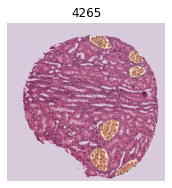

In [30]:
train_batch = next(iter(data_module.train_dataloader()))
show_batch(train_batch, nrows)

## Test Images

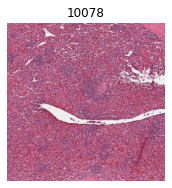

In [27]:
test_batch = next(iter(data_module.test_dataloader()))
show_batch(test_batch, nrows, show_mask=False)

# Lightning Module

In [39]:
class LitModule(pl.LightningModule):
    def __init__(
        self,
        learning_rate: float,
        weight_decay: float,
    ):
        super().__init__()

        self.save_hyperparameters()

        self.model = self._init_model()

        self.loss_fn = self._init_loss_fn()

        # TODO: add metric

    def _init_model(self) -> nn.Module:
        # TODO: try other networks
        return monai.networks.nets.UNet(
            spatial_dims=2,
            in_channels=3,
            out_channels=1,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2,
        )

    def _init_loss_fn(self):
        # TODO: try other losses
        return monai.losses.DiceLoss(sigmoid=True)

    def configure_optimizers(self):
        # TODO: try other optimizers and schedulers
        return torch.optim.Adam(
            params=self.parameters(), lr=self.hparams.learning_rate, weight_decay=self.hparams.weight_decay
        )

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        return self.model(images)

    def training_step(self, batch: Dict, batch_idx: int) -> torch.Tensor:
        images, masks = batch["image"], batch["mask"]
        outputs = self(images)

        loss = self.loss_fn(outputs, masks)

        self.log("train_loss", loss, batch_size=images.shape[0])

        return loss

    def validation_step(self, batch: Dict, batch_idx: int) -> None:
        images, masks = batch["image"], batch["mask"]
        outputs = self(images)

        loss = self.loss_fn(outputs, masks)

        self.log("val_loss", loss, prog_bar=True, batch_size=images.shape[0])

    @classmethod
    def load_eval_checkpoint(cls, checkpoint_path: str, device: str) -> nn.Module:
        module = cls.load_from_checkpoint(checkpoint_path=checkpoint_path).to(device)
        module.eval()

        return module

# Train

In [40]:
GPUS

[3]

In [41]:
def train(
    random_seed: int = RANDOM_SEED,
    train_csv_path: str = str(TRAIN_PREPARED_CSV_PATH),
    test_csv_path: str = str(TEST_PREPARED_CSV_PATH),
    spatial_size: Tuple[int, int] = SPATIAL_SIZE,
    val_fold: str = VAL_FOLD,
    batch_size: int = BATCH_SIZE,
    num_workers: int = NUM_WORKERS,
    learning_rate: float = LEARNING_RATE,
    weight_decay: float = WEIGHT_DECAY,
    fast_dev_run: bool = FAST_DEV_RUN,
    gpus: int = GPUS,
    max_epochs: int = MAX_EPOCHS,
    precision: int = PRECISION,
    debug: bool = DEBUG,
) -> None:
    pl.seed_everything(random_seed)

    data_module = LitDataModule(
        train_csv_path=train_csv_path,
        test_csv_path=test_csv_path,
        spatial_size=spatial_size,
        val_fold=val_fold,
        batch_size=2 if debug else batch_size,
        num_workers=num_workers,
    )

    module = LitModule(
        learning_rate=learning_rate,
        weight_decay=weight_decay,
    )

    trainer = pl.Trainer(
        fast_dev_run=fast_dev_run,
        gpus=gpus,
        limit_train_batches=0.1 if debug else 1.0,
        limit_val_batches=0.1 if debug else 1.0,
        log_every_n_steps=5,
        logger=pl.loggers.CSVLogger(save_dir='logs/'),
        max_epochs=2 if debug else max_epochs,
        precision=precision,
    )

    trainer.fit(module, datamodule=data_module)
    
    return trainer

In [ ]:
trainer = train(num_workers=0)

Global seed set to 2022
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name    | Type     | Params
-------------------------------------
0 | model   | UNet     | 1.6 M 
1 | loss_fn | DiceLoss | 0     
-------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
3.251     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

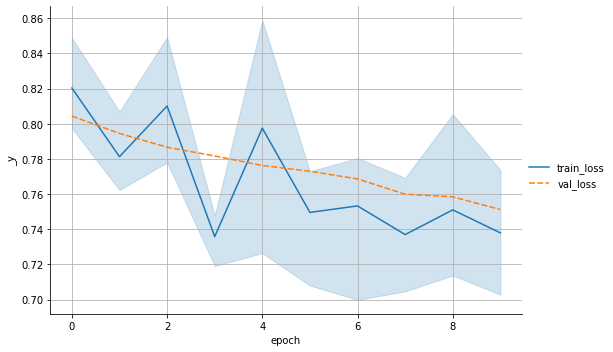

In [19]:
# From https://www.kaggle.com/code/jirkaborovec?scriptVersionId=93358967&cellId=22
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")[["epoch", "train_loss", "val_loss"]]
metrics.set_index("epoch", inplace=True)

sns.relplot(data=metrics, kind="line", height=5, aspect=1.5)
plt.grid()

# Infer

In [20]:
def mask2rle(img):
    '''
    Efficient implementation of mask2rle, from @paulorzp
    --
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    Source: https://www.kaggle.com/xhlulu/efficient-mask2rle
    '''
    pixels = img.T.flatten()
    pixels = np.pad(pixels, ((1, 1), ))
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


@torch.no_grad()
def create_pred_df(module, dataloader, threshold):
    ids = []
    rles = []
    for batch in tqdm(dataloader):
        id_ = batch["id"].numpy()[0]
        height = batch["img_height"].numpy()[0]
        width = batch["img_width"].numpy()[0]
        
        images = batch["image"].to(module.device)
        outputs = module(images)[0]
        
        post_pred_transform = monai.transforms.Compose(
            [
                monai.transforms.Resize(spatial_size=(height, width), mode="nearest"),
                monai.transforms.Activations(sigmoid=True),
                monai.transforms.AsDiscrete(threshold=threshold),
            ]
        )
        
        mask = post_pred_transform(outputs).to(torch.uint8).cpu().detach().numpy()[0]
        
        rle = mask2rle(mask)
        
        ids.append(id_)
        rles.append(rle)
        
    return pd.DataFrame({"id": ids, "rle": rles})


def infer(
    checkpoint_path: str,
    device: str = DEVICE,
    train_csv_path: str = TRAIN_PREPARED_CSV_PATH,
    test_csv_path: str = TEST_PREPARED_CSV_PATH,
    spatial_size: int = SPATIAL_SIZE,
    num_workers: int = NUM_WORKERS,
    threshold: float = THRESHOLD,
):
    module = LitModule.load_eval_checkpoint(checkpoint_path, device)

    data_module = LitDataModule(
        train_csv_path=train_csv_path,
        test_csv_path=test_csv_path,
        spatial_size=spatial_size,
        val_fold=0,
        batch_size=1,
        num_workers=num_workers,
    )
    data_module.setup()
    
    val_dataloader = data_module.val_dataloader()
    test_dataloader = data_module.test_dataloader()
    
    val_pred_df = create_pred_df(module, val_dataloader, threshold)
    test_pred_df = create_pred_df(module, test_dataloader, threshold)
    
    return val_pred_df, test_pred_df


In [21]:
checkpoint_path = list((Path(trainer.logger.log_dir) / "checkpoints").glob("*.ckpt"))[0]
val_pred_df, test_pred_df = infer(checkpoint_path)

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

# Submit

In [22]:
test_pred_df.to_csv("submission.csv", index=False)
test_pred_df

,id,rle
0,10078,144 2 410 127 539 2 1116 2 1572 4 1578 4 2167 ...


## Visualize Val Predictions

In [23]:
val_pred_df = add_path_to_df(val_pred_df, COMPETITION_DATA_DIR, "mask", "pred")
val_pred_df

,id,rle,mask
0,10274,9004 3 12004 3 15004 3 565528 9 565543 2 56554...,pred_masks/10274.npy
1,10392,1 6 3001 6 6001 6 9004 6 12004 6 15004 6 18001...,pred_masks/10392.npy
2,10488,1768918 2 1771918 2 1774918 2 1777888 3 177790...,pred_masks/10488.npy
3,10971,9004 3 12004 3 15004 3 27004 3 30004 3 33004 3...,pred_masks/10971.npy
4,11662,538710 2 538718 33 538753 3 541710 2 541718 33...,pred_masks/11662.npy
...,...,...,...
83,9407,9004 3 12004 3 15004 3 610575 9 613575 9 61657...,pred_masks/9407.npy
84,9437,592475 18 595475 18 598475 18 601469 30 604469...,pred_masks/9437.npy
85,9769,9214 3 12284 3 15354 3 480489 3 480501 3 48050...,pred_masks/9769.npy
86,9791,1449 3 1484 3 1493 6 1507 3 1513 419 4449 3 44...,pred_masks/9791.npy


In [24]:
val_df = train_df[train_df.fold == VAL_FOLD].reset_index(drop=True)
val_df

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,image,mask,fold
0,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,/kaggle/input/hubmap-organ-segmentation/train_...,train_masks/10274.npy,0.0
1,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,/kaggle/input/hubmap-organ-segmentation/train_...,train_masks/10392.npy,0.0
2,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,/kaggle/input/hubmap-organ-segmentation/train_...,train_masks/10488.npy,0.0
3,10971,prostate,HPA,3000,3000,0.4,4,1507862 60 1510857 69 1513853 77 1516848 86 15...,60.0,Male,/kaggle/input/hubmap-organ-segmentation/train_...,train_masks/10971.npy,0.0
4,11662,largeintestine,HPA,3000,3000,0.4,4,673655 29 676649 41 679645 47 682638 59 685636...,84.0,Female,/kaggle/input/hubmap-organ-segmentation/train_...,train_masks/11662.npy,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,9407,spleen,HPA,3000,3000,0.4,4,2184669 23 2187667 27 2190665 31 2193661 37 21...,57.0,Male,/kaggle/input/hubmap-organ-segmentation/train_...,train_masks/9407.npy,0.0
84,9437,kidney,HPA,3000,3000,0.4,4,841572 20 844566 38 847564 45 850563 50 853555...,68.0,Female,/kaggle/input/hubmap-organ-segmentation/train_...,train_masks/9437.npy,0.0
85,9769,kidney,HPA,3070,3070,0.4,4,4030400 28 4033466 34 4036526 48 4039594 54 40...,28.0,Male,/kaggle/input/hubmap-organ-segmentation/train_...,train_masks/9769.npy,0.0
86,9791,kidney,HPA,3000,3000,0.4,4,334733 33 337729 43 340729 43 343725 51 346723...,28.0,Male,/kaggle/input/hubmap-organ-segmentation/train_...,train_masks/9791.npy,0.0


In [25]:
val_pred_df = val_pred_df.merge(val_df, on="id", suffixes=("", "_gt"))
val_pred_df

,id,rle,mask,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle_gt,age,sex,image,mask_gt,fold
0,10274,9004 3 12004 3 15004 3 565528 9 565543 2 56554...,pred_masks/10274.npy,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,/kaggle/input/hubmap-organ-segmentation/train_...,train_masks/10274.npy,0.0
1,10392,1 6 3001 6 6001 6 9004 6 12004 6 15004 6 18001...,pred_masks/10392.npy,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,/kaggle/input/hubmap-organ-segmentation/train_...,train_masks/10392.npy,0.0
2,10488,1768918 2 1771918 2 1774918 2 1777888 3 177790...,pred_masks/10488.npy,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,/kaggle/input/hubmap-organ-segmentation/train_...,train_masks/10488.npy,0.0
3,10971,9004 3 12004 3 15004 3 27004 3 30004 3 33004 3...,pred_masks/10971.npy,prostate,HPA,3000,3000,0.4,4,1507862 60 1510857 69 1513853 77 1516848 86 15...,60.0,Male,/kaggle/input/hubmap-organ-segmentation/train_...,train_masks/10971.npy,0.0
4,11662,538710 2 538718 33 538753 3 541710 2 541718 33...,pred_masks/11662.npy,largeintestine,HPA,3000,3000,0.4,4,673655 29 676649 41 679645 47 682638 59 685636...,84.0,Female,/kaggle/input/hubmap-organ-segmentation/train_...,train_masks/11662.npy,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,9407,9004 3 12004 3 15004 3 610575 9 613575 9 61657...,pred_masks/9407.npy,spleen,HPA,3000,3000,0.4,4,2184669 23 2187667 27 2190665 31 2193661 37 21...,57.0,Male,/kaggle/input/hubmap-organ-segmentation/train_...,train_masks/9407.npy,0.0
84,9437,592475 18 595475 18 598475 18 601469 30 604469...,pred_masks/9437.npy,kidney,HPA,3000,3000,0.4,4,841572 20 844566 38 847564 45 850563 50 853555...,68.0,Female,/kaggle/input/hubmap-organ-segmentation/train_...,train_masks/9437.npy,0.0
85,9769,9214 3 12284 3 15354 3 480489 3 480501 3 48050...,pred_masks/9769.npy,kidney,HPA,3070,3070,0.4,4,4030400 28 4033466 34 4036526 48 4039594 54 40...,28.0,Male,/kaggle/input/hubmap-organ-segmentation/train_...,train_masks/9769.npy,0.0
86,9791,1449 3 1484 3 1493 6 1507 3 1513 419 4449 3 44...,pred_masks/9791.npy,kidney,HPA,3000,3000,0.4,4,334733 33 337729 43 340729 43 343725 51 346723...,28.0,Male,/kaggle/input/hubmap-organ-segmentation/train_...,train_masks/9791.npy,0.0


In [26]:
save_masks(val_pred_df)

  0%|          | 0/88 [00:00<?, ?it/s]

In [27]:
val_pred_df.to_csv(VAL_PRED_PREPARED_CSV_PATH, index=False)

## GT Val Images

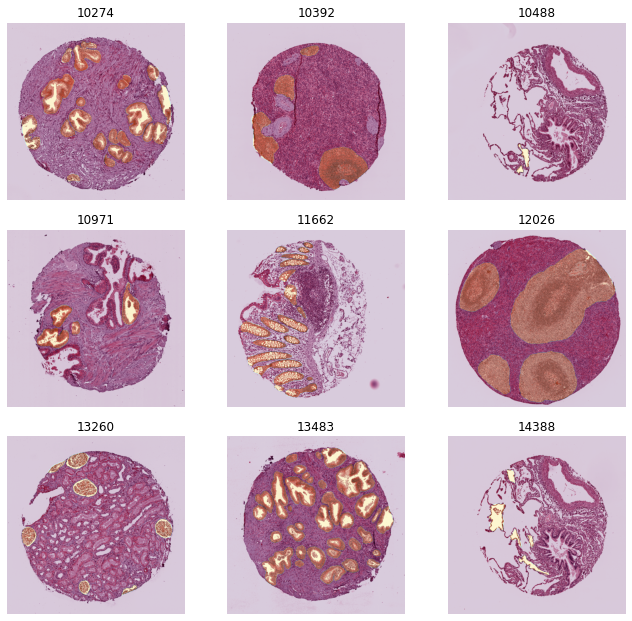

In [28]:
nrows = 3

data_module = LitDataModule(
    train_csv_path=TRAIN_PREPARED_CSV_PATH,
    test_csv_path=TEST_PREPARED_CSV_PATH,
    spatial_size=SPATIAL_SIZE,
    val_fold=VAL_FOLD,
    batch_size=nrows ** 2,
    num_workers=0,
)
data_module.setup()

val_batch = next(iter(data_module.val_dataloader()))
show_batch(val_batch, nrows)

## Pred Val Images

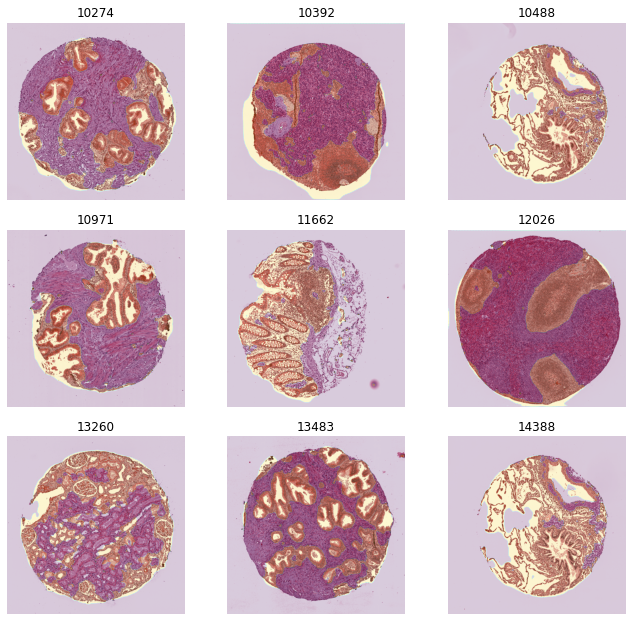

In [29]:
data_module = LitDataModule(
    train_csv_path=VAL_PRED_PREPARED_CSV_PATH,
    test_csv_path=TEST_PREPARED_CSV_PATH,
    spatial_size=SPATIAL_SIZE,
    val_fold=VAL_FOLD,
    batch_size=nrows ** 2,
    num_workers=0,
)
data_module.setup()

val_batch = next(iter(data_module.val_dataloader()))
show_batch(val_batch, nrows)